In [140]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import precision_recall_curve, f1_score

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable as V
from torch.optim import lr_scheduler
import torch.nn.utils as utils


import gc
gc.enable()

In [2]:
csv_file_path = 'Base.csv'

#csv into pandas dataframe
data = pd.read_csv(csv_file_path)

In [3]:
# Drop columns from the original DataFrame
cols_to_del = ['housing_status', 'device_fraud_count', 'bank_branch_count_8w',
'month', 'prev_address_months_count','bank_months_count', 'days_since_request', 'proposed_credit_limit']

data.drop(cols_to_del, axis=1, inplace=True)

In [4]:
# Specify columns with special missing value (-1) and replace with NaN
col_with_nan = ['current_address_months_count']
data.loc[:, col_with_nan] = data[col_with_nan].replace(-1, np.nan)

# KNN imputation
knn_imputer = KNNImputer()
data[col_with_nan] = knn_imputer.fit_transform(data[col_with_nan])

# convert it to int if needed
data[col_with_nan] = data[col_with_nan].astype(int)

In [5]:
#for 'proposed_credit_limit' it contain missing layers I do not want to bother with normalizing it now since minmax is not good with outliers
#TODO use RobustScaler
scl = MinMaxScaler()

def scaler(scl, column_name):
    data[column_name] = scl.fit_transform(data[column_name].values.reshape(-1,1))
    return data

# Columns to scale
to_scale = [col for col in data.columns if col not in ['device_os','source', 'payment_type', 'fraud_bool', 'employment_status']]


# Fit the scaler on the selected columns and transform the data
for col in to_scale:
    data_scaled = scaler(scl, col)


In [6]:
data.head()

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,...,email_is_free,phone_home_valid,phone_mobile_valid,has_other_cards,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w
0,1,1.0,0.166766,0.226221,0.500,0.066361,AA,0.118797,0.653824,0.222822,...,0.0,1.0,0.0,0.0,0.0,INTERNET,0.057932,windows,0.0,0.666667
1,1,1.0,0.296236,0.370180,0.500,0.070622,AB,0.056297,0.040011,0.163409,...,1.0,0.0,0.0,0.0,0.0,INTERNET,0.388719,windows,0.0,0.666667
2,1,1.0,0.044912,0.339332,0.375,0.071123,AC,0.134460,0.253246,0.191962,...,1.0,0.0,1.0,0.0,0.0,INTERNET,0.067894,other,0.0,0.666667
3,1,1.0,0.159449,0.056555,0.500,0.067405,AB,0.125155,0.217359,0.340852,...,1.0,0.0,1.0,1.0,0.0,INTERNET,0.036123,linux,0.0,0.666667
4,1,1.0,0.596393,0.560411,0.500,0.070978,AB,0.137562,0.312208,0.170758,...,1.0,1.0,0.0,0.0,0.0,INTERNET,0.056594,macintosh,1.0,0.666667


In [7]:

categorical_cols = ['device_os','source', 'payment_type', 'employment_status']
data= pd.get_dummies(data, columns=categorical_cols, prefix=categorical_cols)

gc.collect()


0

In [8]:
data.head()

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,...,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG
0,1,1.0,0.166766,0.226221,0.500,0.066361,0.118797,0.653824,0.222822,0.240097,...,0,0,0,1,0,0,0,0,0,0
1,1,1.0,0.296236,0.370180,0.500,0.070622,0.056297,0.040011,0.163409,0.051382,...,0,0,0,1,0,0,0,0,0,0
2,1,1.0,0.044912,0.339332,0.375,0.071123,0.134460,0.253246,0.191962,0.060390,...,1,0,0,0,1,0,0,0,0,0
3,1,1.0,0.159449,0.056555,0.500,0.067405,0.125155,0.217359,0.340852,0.025338,...,0,0,0,1,0,0,0,0,0,0
4,1,1.0,0.596393,0.560411,0.500,0.070978,0.137562,0.312208,0.170758,0.042033,...,0,0,0,1,0,0,0,0,0,0


In [9]:
# Check for negative values in the DataFrame
has_negative_values = (data < 0).any().any()

if has_negative_values:
    print("DataFrame contains negative values.")
else:
    print("DataFrame does not contain negative values.")

# Define the threshold
threshold = 1.0

# Find columns with values greater than the threshold
columns_with_values_above_threshold = data.columns[data.gt(threshold).any()]

print("Columns with values greater than", threshold, ":", columns_with_values_above_threshold.tolist())

DataFrame does not contain negative values.
Columns with values greater than 1.0 : ['credit_risk_score']


In [10]:
#train - test split
#using stratified splitting to ensure the fraud exist in both splits
# Prepare feature data (exclude fraud)
# Perform stratified splitting for training and testing
X = data.drop('fraud_bool', axis=1)
y = data['fraud_bool'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def split(data, ratio=0.2):
    threshold = int(ratio*len(data))
    return data[threshold:], data[:threshold]

X_train, X_val = split(X_train)
y_train, y_val = split(y_train)

In [90]:
#hyper-par
batch_size = 500
epochs = 100
encoding_dim = 64
hidden_dim = int(encoding_dim/2)
learning_rate = 1e-3
input_dim = len(X_train.columns)
out_dim = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [104]:
class AE(nn.Module):
    def __init__(self, input_dim, encoding_dim, hidden_dim):
        super(AE, self).__init__()
        #create the layers encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(),
            nn.LayerNorm(encoding_dim),  # Add Layer Normalization
        )

        #init encoder weights
        #for layer in self.encoder:
         #   if isinstance(layer, nn.Linear):
          #      torch.nn.init.kaiming_uniform_(layer.weight)

        # Create the layers for the decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.LayerNorm(input_dim),  # Add Layer Normalization

        )

        # Create the layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(encoding_dim, out_dim),
            nn.LayerNorm(out_dim),  # Add Layer Normalization
            nn.Dropout(0.2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        classification_output = self.classifier(encoded)
        return decoded, classification_output

autoencoder = AE(input_dim, encoding_dim, hidden_dim)
m = autoencoder.to(device)
print(autoencoder)



AE(
  (encoder): Sequential(
    (0): Linear(in_features=38, out_features=64, bias=True)
    (1): ReLU()
    (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=38, bias=True)
    (1): LayerNorm((38,), eps=1e-05, elementwise_affine=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Sigmoid()
  )
)


In [124]:
xtrain = torch.FloatTensor(X_train.values).to(device)
xval = torch.FloatTensor(X_val.values).to(device)
ytrain = torch.FloatTensor(y_train.values).unsqueeze(1).to(device)
yval = torch.FloatTensor(y_val.values).unsqueeze(1).to(device)

# Verify that the numbers of samples match
if len(xtrain) != len(ytrain):
    raise ValueError("Number of samples in xtrain and ytrain do not match.")
if len(xval) != len(yval):
    raise ValueError("Number of samples in xval and yval do not match.")

# Create datasets and dataloaders
train_dataset = TensorDataset(xtrain, ytrain)
train_dl = DataLoader(train_dataset, batch_size=batch_size) #shuffle=True

valid_dataset = TensorDataset(xval, yval)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size)


In [106]:
# Define loss function and optimizer
criterion_recon = nn.MSELoss()         #mean sqr error
criterion_classification = nn.BCELoss()
optimizer = torch.optim.Adam(m.parameters(), lr = learning_rate, weight_decay=0.001)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


In [107]:
train_losses = []
val_losses = []

for epoch in range(epochs):
    autoencoder.train()  # Set the model to training mode
    for batch_data, batch_labels in train_dl:
        batch_data = batch_data.to(device)  # Move batch_data to the same device
        batch_labels = batch_labels.to(device)  # Move target_data to the same device

        optimizer.zero_grad()  # Clear gradients
        decoded_output, classification_output = autoencoder(batch_data)

        reconstruction_loss = criterion_recon(decoded_output, batch_data)  # Autoencoder reconstruction loss
        classification_loss = criterion_classification(classification_output, batch_labels)  # Classification loss
        total_loss = reconstruction_loss + classification_loss

        total_loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
        #utils.clip_grad_norm_(m.parameters(), max_norm=1.0)  # Apply gradient clipping
        #scheduler.step()
        train_losses.append(total_loss.item())
        print(f'Epoch [{epoch+1}/{epochs}], Batch Loss: {total_loss.item():.4f}')

    autoencoder.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_loss = 0
        for batch_data, batch_labels in valid_dl:
            batch_data = batch_data.to(device)  # Move batch_data to the same device
            batch_labels = batch_labels.to(device)  # Move target_data to the same device
            decoded_output, classification_output = autoencoder(batch_data)

            reconstruction_loss = criterion_recon(decoded_output, batch_data)  # Autoencoder reconstruction loss
            classification_loss = criterion_classification(classification_output, batch_labels)

            total_loss += (reconstruction_loss + classification_loss).item() * len(batch_data)

        average_loss = total_loss / len(valid_dl)
        val_losses.append(average_loss)
        # Print and visualize the loss values
    #print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {average_loss:.4f}')

# Save the trained model
torch.save(m.state_dict(), "autoencoder_classifier.pth")

Epoch [1/100], Batch Loss: 1.8214
Epoch [1/100], Batch Loss: 1.7841
Epoch [1/100], Batch Loss: 1.7343
Epoch [1/100], Batch Loss: 1.6853
Epoch [1/100], Batch Loss: 1.6459
Epoch [1/100], Batch Loss: 1.6091
Epoch [1/100], Batch Loss: 1.5676
Epoch [1/100], Batch Loss: 1.5445
Epoch [1/100], Batch Loss: 1.5123
Epoch [1/100], Batch Loss: 1.4904
Epoch [1/100], Batch Loss: 1.4592
Epoch [1/100], Batch Loss: 1.4433
Epoch [1/100], Batch Loss: 1.4250
Epoch [1/100], Batch Loss: 1.4155
Epoch [1/100], Batch Loss: 1.4050
Epoch [1/100], Batch Loss: 1.3777
Epoch [1/100], Batch Loss: 1.3713
Epoch [1/100], Batch Loss: 1.3639
Epoch [1/100], Batch Loss: 1.3510
Epoch [1/100], Batch Loss: 1.3374
Epoch [1/100], Batch Loss: 1.3298
Epoch [1/100], Batch Loss: 1.3285
Epoch [1/100], Batch Loss: 1.3132
Epoch [1/100], Batch Loss: 1.3145
Epoch [1/100], Batch Loss: 1.3018
Epoch [1/100], Batch Loss: 1.2938
Epoch [1/100], Batch Loss: 1.2881
Epoch [1/100], Batch Loss: 1.2873
Epoch [1/100], Batch Loss: 1.2826
Epoch [1/100],

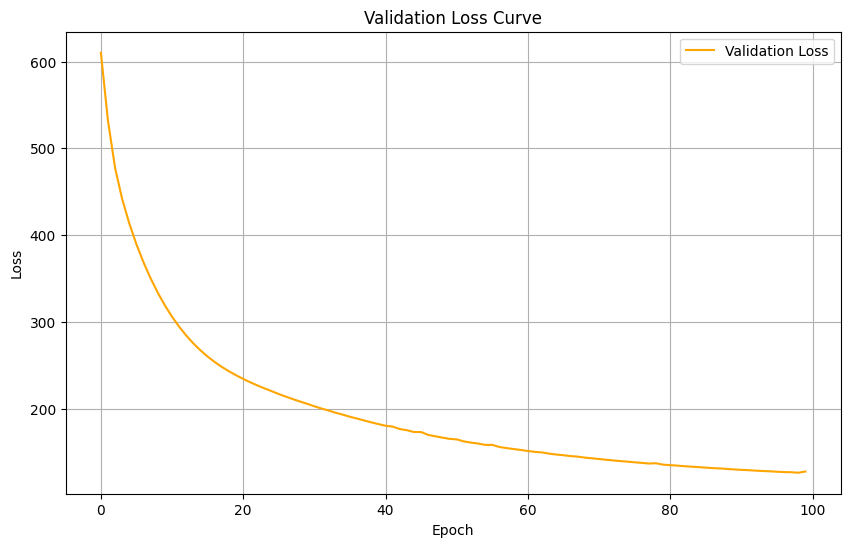

In [118]:
# Plotting the validation loss curve
plt.figure(figsize=(10, 6))
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Curve')
plt.legend()
plt.grid()
plt.show()

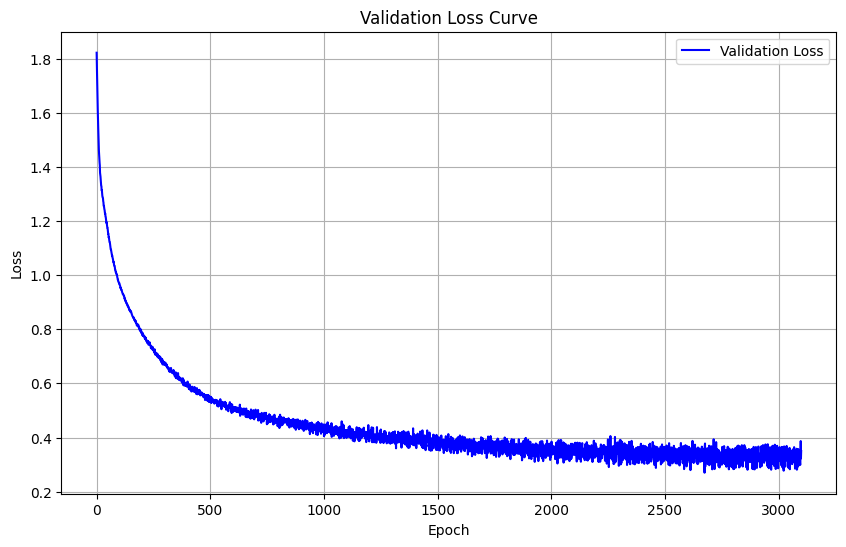

In [114]:
# Plotting the loss curves after all epochs
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [138]:
autoencoder.eval()  # Set the model to evaluation mode
with torch.no_grad():
    valid_x_predictions, _ = autoencoder(xval)  # Use the model's forward pass for reconstruction
    mse = torch.mean(torch.pow(xval - valid_x_predictions, 2), dim=1).cpu().numpy()

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_val.values})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)


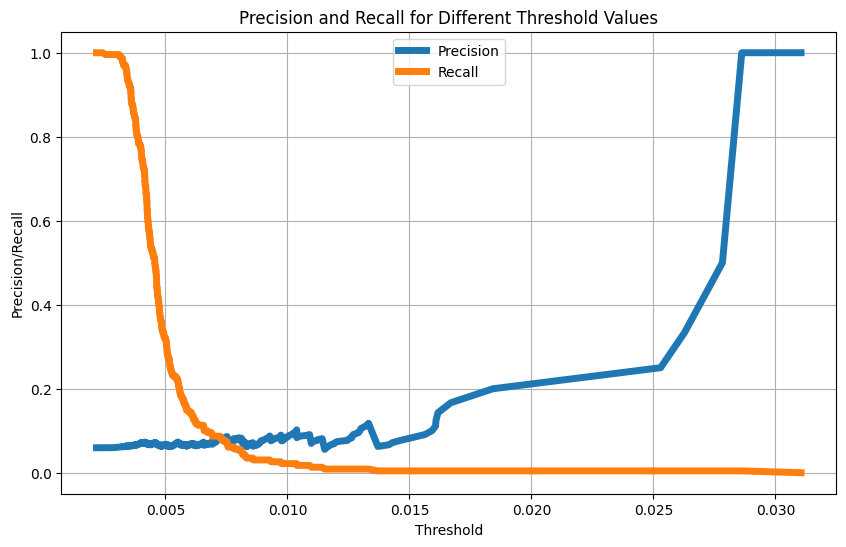

In [139]:
# Plotting the precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(threshold_rt, precision_rt[1:], label="Precision", linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall", linewidth=5)
plt.title('Precision and Recall for Different Threshold Values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.grid()
plt.show()

In [141]:
# Calculate the F1-score
f1_scores = 2 * (precision_rt * recall_rt) / (precision_rt + recall_rt)
best_f1_index = np.argmax(f1_scores)
best_f1_threshold = threshold_rt[best_f1_index]
best_f1 = f1_scores[best_f1_index]

print("Best F1-score:", best_f1)
print("Best F1-score Threshold:", best_f1_threshold)

Best F1-score: 0.13185067513899923
Best F1-score Threshold: 0.004131835


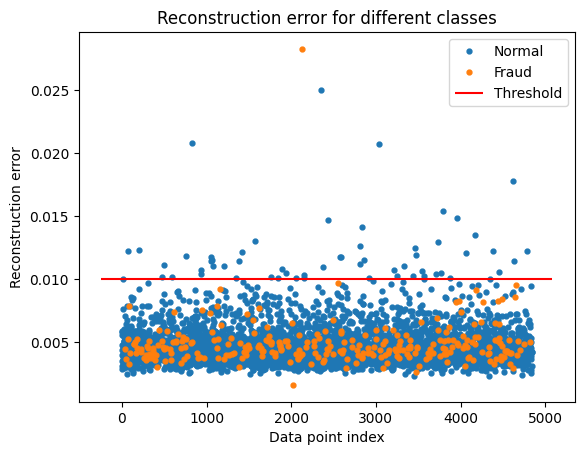

In [135]:
xtest = torch.FloatTensor(X_test.values).to(device)

# Calculate reconstruction errors
autoencoder.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_x_predictions, _ = autoencoder(xtest)  # Use the model's forward pass for reconstruction
    test_x_predictions_cpu = test_x_predictions.cpu()  # Move the predictions to CPU

mse = np.mean(np.power(xtest.cpu().numpy() - test_x_predictions_cpu.numpy(), 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                              'True_class': y_test.values})

error_df_test = error_df_test.reset_index()
threshold_fixed = 0.010
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label="Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()
